In [1]:
#@ogozuacik

from datetime import timedelta
from gc import collect
from haversine import haversine
import lightgbm as lgb
import pandas as pd
import optuna
import os
import shap
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit #, KFold
from skmob import TrajDataFrame
from skmob.preprocessing import clustering
from tqdm import tqdm_notebook

In [2]:
A_DAY_IN_SECONDS = 60 * 60 * 24
CO2_PER_MILE = 404
NUM_BOOSTING_ROUNDS = 100
NUM_TRIALS = 25  # higher values should do better
KM_TO_MILES = 0.62137

In [3]:
# ref: https://stackoverflow.com/questions/579310/formatting-long-numbers-as-strings
def human_readable_format(value):
    """Converts the value to human readable format"""
    value = float("{:.3g}".format(value))
    magnitude = 0
    while abs(value) >= 1000:
        magnitude += 1
        value /= 1000.0
    return "{}{}".format("{:f}".format(value).rstrip("0").rstrip("."), ["", "K", "M", "B", "T"][magnitude])

## Importing data and pre-processing

In [4]:
def pre_process_change_points_and_trip_ids(df, trip_id):
    """Pre-processes change points and assigns trip ids"""
    prev_occupancy = 1
    is_change_point = []
    trip_ids = []
    for occupancy in df["occupancy"]:
        if occupancy != prev_occupancy:
            is_change_point.append(True)
            trip_id += 1
        else:
            is_change_point.append(False)
        trip_ids.append(trip_id)
        prev_occupancy = occupancy
    is_change_point[-1] = True if occupancy == 1 else False
    df["is_change_point"] = is_change_point
    df["tid"] = trip_ids
    return df, trip_id

In [5]:
# reading data and combining them in one dataframe
dfs = []
# starting from 0 to ...
trip_id = 0
for root, _, files in os.walk("cabspottingdata"):
    for file_ in files:
        if not file_.endswith(".txt"):
            continue
        df = pd.read_csv(
            os.path.join(root, file_), sep=" ", header=None, names=["lat", "lng", "occupancy", "datetime"])
        df["datetime"] = pd.to_datetime(df["datetime"], unit="s") + timedelta(minutes=-7*60)
        taxi_id = file_.split(".txt")[0]
        # user id
        df["uid"] = taxi_id
        df, trip_id = pre_process_change_points_and_trip_ids(df, trip_id)
        df["prev_lat"] = df["lat"].shift()
        df["prev_lng"] = df["lng"].shift()
        df["prev_datetime"] = df["datetime"].shift()
        trip_id += 1
        dfs.append(df)

In [6]:
# combining data from different taxis together
combined_df = pd.concat(dfs).reset_index(drop=True)
del dfs
collect()

0

In [7]:
# total number of rows
num_rows = len(combined_df)
human_readable_format(num_rows)

'11.2M'

In [8]:
combined_df

,lat,lng,occupancy,datetime,uid,is_change_point,tid,prev_lat,prev_lng,prev_datetime
0,37.75153,-122.39447,0,2008-05-17 07:12:10,new_abboip,True,1,NaN,NaN,NaT
1,37.75149,-122.39447,0,2008-05-17 07:13:34,new_abboip,False,1,37.75153,-122.39447,2008-05-17 07:12:10
2,37.75149,-122.39447,0,2008-05-17 07:14:34,new_abboip,False,1,37.75149,-122.39447,2008-05-17 07:13:34
3,37.75149,-122.39446,0,2008-05-17 07:15:35,new_abboip,False,1,37.75149,-122.39447,2008-05-17 07:14:34
4,37.75144,-122.39449,0,2008-05-17 07:41:43,new_abboip,False,1,37.75149,-122.39446,2008-05-17 07:15:35
...,...,...,...,...,...,...,...,...,...,...
11220053,37.74654,-122.44338,1,2008-06-09 11:18:11,new_uvreoipy,False,928700,37.74501,-122.44424,2008-06-09 11:17:13
11220054,37.75140,-122.44296,1,2008-06-09 11:19:08,new_uvreoipy,False,928700,37.74654,-122.44338,2008-06-09 11:18:11
11220055,37.75686,-122.44239,1,2008-06-09 11:20:12,new_uvreoipy,False,928700,37.75140,-122.44296,2008-06-09 11:19:08
11220056,37.76047,-122.44215,1,2008-06-09 11:21:08,new_uvreoipy,False,928700,37.75686,-122.44239,2008-06-09 11:20:12


In [9]:
# assuming dist covered is continuous data
combined_df["dist_covered"] = combined_df.apply(
    lambda x: haversine((x["prev_lat"], x["prev_lng"]), (x["lat"], x["lng"])), axis=1)
combined_df["km_per_hour"] = combined_df["dist_covered"] / \
    ((combined_df["datetime"] - combined_df["prev_datetime"]).apply(lambda x: x.total_seconds()) / 3600)

In [10]:
# removal of data with speed more than 300km/h
combined_df = combined_df[(combined_df["km_per_hour"] < 300) | (combined_df["km_per_hour"].isnull())]

In [11]:
# number of removed rows
human_readable_format(num_rows - len(combined_df))

'57.3K'

## Basic EDA

Analysis done for samples where occupancy = 1

In [12]:
combined_df.head()

,lat,lng,occupancy,datetime,uid,is_change_point,tid,prev_lat,prev_lng,prev_datetime,dist_covered,km_per_hour
0,37.75153,-122.39447,0,2008-05-17 07:12:10,new_abboip,True,1,NaN,NaN,NaT,NaN,NaN
1,37.75149,-122.39447,0,2008-05-17 07:13:34,new_abboip,False,1,37.75153,-122.39447,2008-05-17 07:12:10,0.004448,0.190620
2,37.75149,-122.39447,0,2008-05-17 07:14:34,new_abboip,False,1,37.75149,-122.39447,2008-05-17 07:13:34,0.000000,0.000000
3,37.75149,-122.39446,0,2008-05-17 07:15:35,new_abboip,False,1,37.75149,-122.39447,2008-05-17 07:14:34,0.000879,0.051887
4,37.75144,-122.39449,0,2008-05-17 07:41:43,new_abboip,False,1,37.75149,-122.39446,2008-05-17 07:15:35,0.006154,0.014128


### Taxi id based analysis of trips

In [13]:
def day_range(series):
    """Returns the day range"""
    diff = series.max() - series.min()
    return diff.total_seconds() / A_DAY_IN_SECONDS

grouped_df = combined_df[combined_df["occupancy"] == 1].groupby("uid").agg(
    number_of_trips=pd.NamedAgg(column="tid", aggfunc="nunique"),
    total_dist_covered=pd.NamedAgg(column="dist_covered", aggfunc="sum"),
    days_active=pd.NamedAgg(column="datetime", aggfunc=day_range))
grouped_df["average_trip_distance"] = grouped_df["total_dist_covered"] / grouped_df["number_of_trips"]
grouped_df["distance_covered_per_day"] = grouped_df["total_dist_covered"] / grouped_df["days_active"]

In [14]:
grouped_df.head()

,number_of_trips,total_dist_covered,days_active,average_trip_distance,distance_covered_per_day
uid,,,,,
new_abboip,957,4100.611079,23.701910,4.284860,173.007624
new_abcoij,28,95.550352,16.684109,3.412513,5.727028
new_abdremlu,881,7656.255412,23.161088,8.690415,330.565448
new_abgibo,1032,5665.364915,23.962153,5.489695,236.429713
new_abjoolaw,396,2097.224778,23.200775,5.296022,90.394598


array([[<AxesSubplot:title={'center':'number_of_trips'}>,
        <AxesSubplot:title={'center':'total_dist_covered'}>],
       [<AxesSubplot:title={'center':'days_active'}>,
        <AxesSubplot:title={'center':'average_trip_distance'}>],
       [<AxesSubplot:title={'center':'distance_covered_per_day'}>,
        <AxesSubplot:>]], dtype=object)

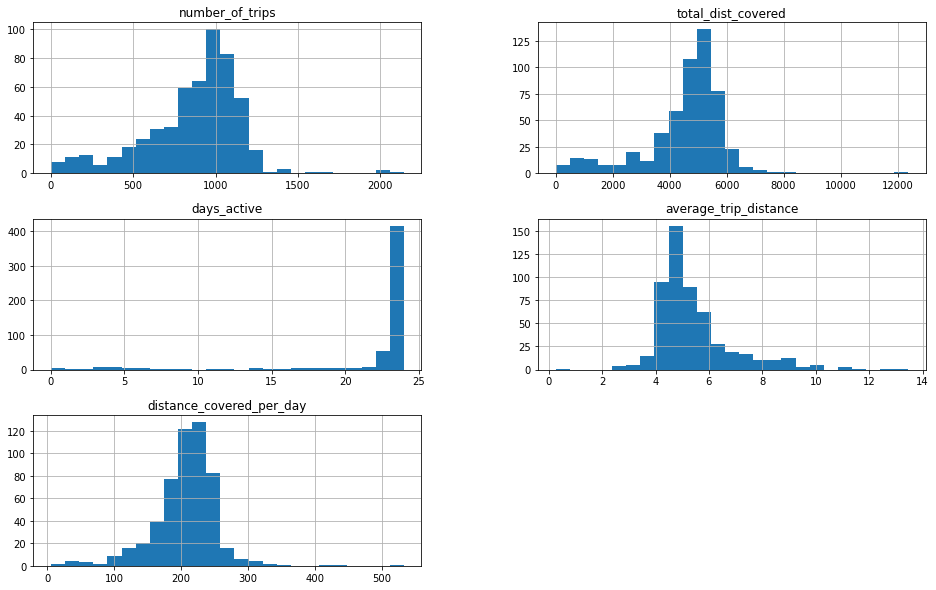

In [15]:
grouped_df.hist(bins=25, figsize=(16,10)) 

In [16]:
# median of the metrics for all taxi ids
grouped_df.median().apply(human_readable_format)

number_of_trips               931
total_dist_covered          4.86K
days_active                  23.3
average_trip_distance        4.96
distance_covered_per_day      213
dtype: object

In [17]:
# sum of the metrics for all taxi ids
grouped_df.sum().apply(human_readable_format)

number_of_trips              464K
total_dist_covered          2.43M
days_active                 11.7K
average_trip_distance       2.91K
distance_covered_per_day     111K
dtype: object

### Temporal analysis of trips

In [18]:
grouped_df = combined_df[combined_df["occupancy"] == 1].groupby( 
    combined_df["datetime"].map(lambda x : x.hour)).agg(
        number_of_trips=pd.NamedAgg(column="tid", aggfunc="nunique"),
        total_dist_covered=pd.NamedAgg(column="dist_covered", aggfunc="sum"))
grouped_df.index.names = ["hour_of_day"]

<AxesSubplot:xlabel='hour_of_day'>

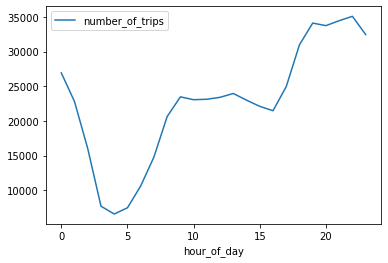

In [19]:
grouped_df["number_of_trips"].plot(legend=True)

<AxesSubplot:xlabel='hour_of_day'>

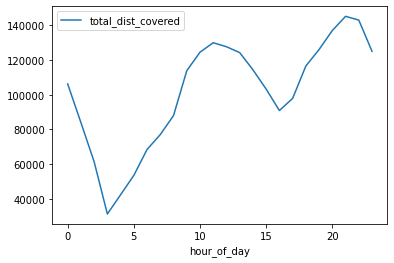

In [20]:
grouped_df["total_dist_covered"].plot(legend=True)

In [21]:
# total number of trips peaks at 22
human_readable_format(grouped_df.idxmax()["number_of_trips"]), \
    human_readable_format(grouped_df.max()["number_of_trips"])

('22', '35.1K')

In [22]:
# total number of trips troughs at 4
human_readable_format(grouped_df.idxmin()["number_of_trips"]), \
    human_readable_format(grouped_df.min()["number_of_trips"])

('4', '6.58K')

In [23]:
# total dist covered peaks at 21
human_readable_format(grouped_df.idxmax()["total_dist_covered"]), \
    human_readable_format(grouped_df.max()["total_dist_covered"])

('21', '145K')

In [24]:
# total dist covered troughs at 3
human_readable_format(grouped_df.idxmin()["total_dist_covered"]), \
    human_readable_format(grouped_df.min()["total_dist_covered"])

('3', '31.2K')

In [25]:
grouped_df = combined_df[combined_df["occupancy"] == 1].groupby( 
    combined_df["datetime"].map(lambda x : x.day_of_week)).agg(
        number_of_trips=pd.NamedAgg(column="tid", aggfunc="nunique"),
        total_dist_covered=pd.NamedAgg(column="dist_covered", aggfunc="sum"))
grouped_df.index.names = ["day_of_week"]
grouped_df.index = grouped_df.index.map({
    0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"})

<AxesSubplot:xlabel='day_of_week'>

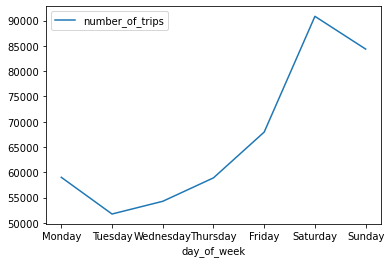

In [26]:
grouped_df["number_of_trips"].plot(legend=True)

<AxesSubplot:xlabel='day_of_week'>

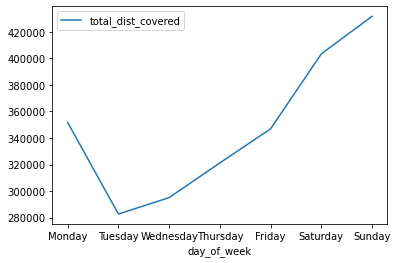

In [27]:
# more distances are covered in Sundays
# people tend to go places that are far usually on weekends
grouped_df["total_dist_covered"].plot(legend=True)

In [28]:
# data is from 17th of May to 10th of July
# however, it is not uniform for each taxi (later analyzed in CO2 emission)
combined_df["datetime"].min(), combined_df["datetime"].max()

(Timestamp('2008-05-17 03:00:04'), Timestamp('2008-06-10 02:25:34'))

### Trip-wise analysis

In [29]:
def minutes(series):
    """Returns the minutes"""
    diff = series.max() - series.min()
    return diff.total_seconds() / 60 

def return_last(series):
    """Returns the last value"""
    return series.values[-1]

grouped_df = combined_df[combined_df["occupancy"] == 1].groupby("tid").agg(
    total_dist_covered=pd.NamedAgg(column="dist_covered", aggfunc="sum"),
    trip_duration=pd.NamedAgg(column="datetime", aggfunc=minutes),
    median_speed=pd.NamedAgg(column="km_per_hour", aggfunc="median"),
    end_lat=pd.NamedAgg(column="lat", aggfunc=return_last),
    end_lng=pd.NamedAgg(column="lng", aggfunc=return_last))

In [30]:
# total_dist_covered(km), trip duration (minutes), avg_speed(km/h), ignore end lat and lng
grouped_df.median().apply(human_readable_format)

total_dist_covered    2.92
trip_duration          8.5
median_speed          18.1
end_lat               37.8
end_lng               -122
dtype: object

<AxesSubplot:>

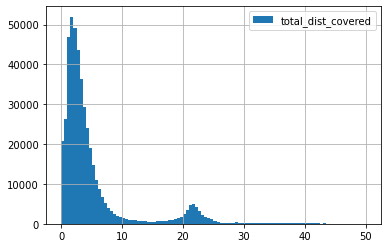

In [31]:
# removing long distance trips as they are relatively few compared to small trips
# peak at 22km is most probably the airport
grouped_df[grouped_df["total_dist_covered"] < 50]["total_dist_covered"].hist(bins=100, legend=True)

In [32]:
# San Francisco International Airport: 37.6213° N, 122.3790° W
# close enough :)
grouped_df[
    (grouped_df["total_dist_covered"] > 15) & (grouped_df["total_dist_covered"] < 28)][["end_lat", "end_lng"]].median()

end_lat     37.721040
end_lng   -122.394495
dtype: float64

<AxesSubplot:>

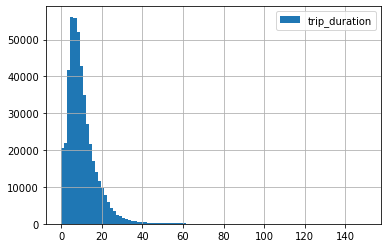

In [33]:
grouped_df[grouped_df["trip_duration"] < 150]["trip_duration"].hist(bins=100, legend=True)

<AxesSubplot:>

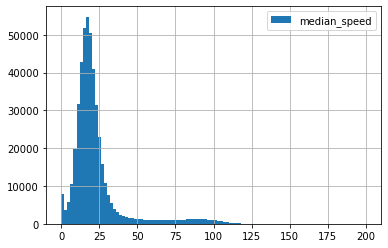

In [34]:
grouped_df[grouped_df["median_speed"] < 200]["median_speed"].hist(bins=100, legend=True)

## CO2 Emission

In [35]:
# samples counts
combined_df["occupancy"].value_counts().apply(human_readable_format)

0    6.17M
1    4.99M
Name: occupancy, dtype: object

In [36]:
distances_df = combined_df[combined_df["occupancy"] == 0].groupby("uid").agg(
    number_of_trips=pd.NamedAgg(column="tid", aggfunc="nunique"),
    total_dist_covered=pd.NamedAgg(column="dist_covered", aggfunc="sum"),
    days_active=pd.NamedAgg(column="datetime", aggfunc=day_range))
distances_df["average_trip_distance"] = distances_df["total_dist_covered"] / distances_df["number_of_trips"]
distances_df["distance_covered_per_day"] = distances_df["total_dist_covered"] / distances_df["days_active"]

In [37]:
# as we can see below, some taxis do not cover a lot of ground
# this data needs to be normalized by the number of days that the taxi is active
distances_df[distances_df["total_dist_covered"] < 100]

,number_of_trips,total_dist_covered,days_active,average_trip_distance,distance_covered_per_day
uid,,,,,
new_egoiwroi,2,2.035594,0.123495,1.017797,16.483157
new_eotcue,3,5.539578,9.586690,1.846526,0.577840
new_ifeshce,8,12.721671,10.807512,1.590209,1.177114
new_mfeuer,3,27.189946,0.083600,9.063315,325.240390


In [38]:
human_readable_format(distances_df["total_dist_covered"].sum())

'1.86M'

In [39]:
# getting the median in order to eliminate the effect of outliers (increasing mean)
distances_df.median().apply(human_readable_format)

number_of_trips               930
total_dist_covered          3.64K
days_active                  23.3
average_trip_distance        3.76
distance_covered_per_day      158
dtype: object

<AxesSubplot:>

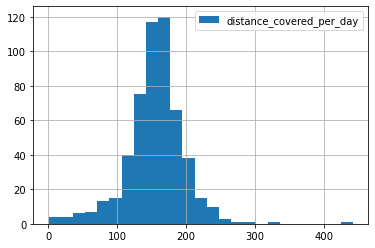

In [40]:
distances_df["distance_covered_per_day"].hist(bins=25, legend=True)

In [41]:
# these may be faulty data due to gps, and an error calculating number of days active for taxi drivers
distances_df["distance_covered_per_day"].min(), distances_df["distance_covered_per_day"].max()

(0.5778404957822241, 442.3276073169632)

In [42]:
# CO2 emission per taxi during idle time daily
co2_emission_per_taxi = distances_df["distance_covered_per_day"].median() * KM_TO_MILES * CO2_PER_MILE

monthly_co2_emission = co2_emission_per_taxi * 30
yearly_co2_emission = co2_emission_per_taxi * 365
print(f"Daily: {human_readable_format(co2_emission_per_taxi)}")
print(f"Weekly: {human_readable_format(co2_emission_per_taxi * 7)}")
print(f"Monthly: {human_readable_format(monthly_co2_emission)}")
print(f"Yearly: {human_readable_format(yearly_co2_emission)}")

Daily: 39.8K
Weekly: 279K
Monthly: 1.19M
Yearly: 14.5M


In [43]:
yearly_co2_emission_with_electric_car = sum([monthly_co2_emission * (0.85 ** n) for n in range(1, 13)]) 
print(human_readable_format(yearly_co2_emission_with_electric_car))

5.8M


In [44]:
# around 60% reduction in CO2 emission assuming that the taxi cab fleet is changing at the rate of 15% per month
100 * (yearly_co2_emission - yearly_co2_emission_with_electric_car) / yearly_co2_emission

60.04961608579432

In [45]:
# From 29.9 to 11.9M --> 17.9M CO2 emission reduction per car
human_readable_format(yearly_co2_emission - yearly_co2_emission_with_electric_car)

'8.72M'

In [46]:
# https://www.wikiwand.com/en/Taxis_of_the_United_States
# 1825 taxis in San Francisco

In [47]:
total_emission = 1825 * yearly_co2_emission
total_emission_with_electric_car = 1825 * yearly_co2_emission_with_electric_car
print(f"Total CO2 emission yearly: {human_readable_format(total_emission)}")
print(
    "Total CO2 emission yearly with taxi cab fleet changing at the rate of "
    f"15% per month: {human_readable_format(total_emission_with_electric_car)}")
print(
    "Potential for yearly reduction on CO2 emissions: "
    f"{human_readable_format(total_emission - total_emission_with_electric_car)}")

Total CO2 emission yearly: 26.5B
Total CO2 emission yearly with taxi cab fleet changing at the rate of 15% per month: 10.6B
Potential for yearly reduction on CO2 emissions: 15.9B


## Predictor for taxi drivers, 

Predicting the next place a passenger will hail a cab.

In [ ]:
dfs = []
filtered_combined_df = combined_df[combined_df["is_change_point"] == True]
for uid in tqdm_notebook(combined_df["uid"].unique()):
    df = filtered_combined_df[combined_df["uid"] == uid]
    df["next_lat"] = df["lat"].shift(-1)
    df["next_lng"] = df["lng"].shift(-1)
    dfs.append(df[["lat", "lng", "next_lat", "next_lng", "occupancy", "datetime", "uid", "is_change_point"]])
combined_pred_df = pd.concat(dfs)
del dfs
collect()

In [49]:
combined_pred_df = combined_pred_df[combined_pred_df["occupancy"] == 0].dropna().reset_index(drop=True)

In [50]:
combined_pred_df.head()

,lat,lng,next_lat,next_lng,occupancy,datetime,uid,is_change_point
0,37.75153,-122.39447,37.74977,-122.39724,0,2008-05-17 07:12:10,new_abboip,True
1,37.75580,-122.41441,37.75053,-122.42086,0,2008-05-17 07:56:00,new_abboip,True
2,37.75177,-122.43095,37.77173,-122.41838,0,2008-05-17 08:21:50,new_abboip,True
3,37.77181,-122.41833,37.77181,-122.41833,0,2008-05-17 08:46:06,new_abboip,True
4,37.61736,-122.38765,37.75240,-122.41842,0,2008-05-17 09:02:58,new_abboip,True


In [51]:
def create_date_features(df, date_column_name):
    """Creates date related features from the date column"""
    df[f"hour_{date_column_name}"] = df[date_column_name].dt.hour
    df[f"minute_{date_column_name}"] = df[date_column_name].dt.minute
    df[f"day_of_month_{date_column_name}"] = df[date_column_name].dt.day
    df[f"week_of_month_{date_column_name}"] = \
        (df[date_column_name].apply(lambda d: (d.day-1) // 7 + 1))
    df[f"day_of_week_{date_column_name}"] = (df[date_column_name].dt.dayofweek + 1)
    df[f"is_wknd_{date_column_name}"] = (df[date_column_name].dt.weekday // 4)
    return df  # .drop(date_column_name, axis=1)

<AxesSubplot:>

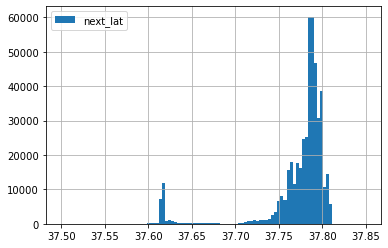

In [52]:
combined_pred_df["next_lat"][(combined_pred_df["next_lat"] > 37.5) & (combined_pred_df["next_lat"] < 37.85)].hist(bins=100, legend=True)

<AxesSubplot:>

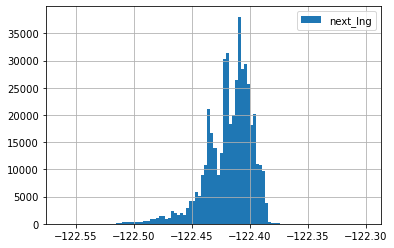

In [53]:
combined_pred_df["next_lng"][(combined_pred_df["next_lng"] > -122.7) & (combined_pred_df["next_lng"] < -122.3)].hist(bins=100, legend=True)

In [54]:
combined_pred_df = create_date_features(combined_pred_df, "datetime")
combined_pred_df.head()

,lat,lng,next_lat,next_lng,occupancy,datetime,uid,is_change_point,hour_datetime,minute_datetime,day_of_month_datetime,week_of_month_datetime,day_of_week_datetime,is_wknd_datetime
0,37.75153,-122.39447,37.74977,-122.39724,0,2008-05-17 07:12:10,new_abboip,True,7,12,17,3,6,1
1,37.75580,-122.41441,37.75053,-122.42086,0,2008-05-17 07:56:00,new_abboip,True,7,56,17,3,6,1
2,37.75177,-122.43095,37.77173,-122.41838,0,2008-05-17 08:21:50,new_abboip,True,8,21,17,3,6,1
3,37.77181,-122.41833,37.77181,-122.41833,0,2008-05-17 08:46:06,new_abboip,True,8,46,17,3,6,1
4,37.61736,-122.38765,37.75240,-122.41842,0,2008-05-17 09:02:58,new_abboip,True,9,2,17,3,6,1


In [55]:
def cross_validate_lgbm(data, label, params):
    """Cross-validates lgbm using time  cross validation"""
    return lgb.cv(
        params,
        lgb.Dataset(data, label=label),
        num_boost_round=NUM_BOOSTING_ROUNDS, # more rounds can be better
        folds=TimeSeriesSplit(), #KFold(), TimeSeriesSplit() 
        metrics="mae")

def objective(trial, data, label):
    """Optuna objective for maximizing auc in lgbm cross validation"""
    params = {
        "objective": "regression_l1", # regression_l1, regression, huber, fair, poisson, quantile, mape, gamma, tweedie
        "metric": "mae",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)}
    cv_results = cross_validate_lgbm(data, label, params)
    return cv_results["l1-mean"][-1]

In [56]:
combined_pred_df.columns

Index(['lat', 'lng', 'next_lat', 'next_lng', 'occupancy', 'datetime', 'uid',
       'is_change_point', 'hour_datetime', 'minute_datetime',
       'day_of_month_datetime', 'week_of_month_datetime',
       'day_of_week_datetime', 'is_wknd_datetime'],
      dtype='object')

In [57]:
combined_pred_df = combined_pred_df.sort_values("datetime")

In [58]:
lng_data = combined_pred_df[[
    "lat", "lng", "hour_datetime", "minute_datetime", "day_of_month_datetime", "week_of_month_datetime", 
    "day_of_week_datetime", "is_wknd_datetime"]]
# data["uid"] = data["uid"].astype("category")
lng_labels = combined_pred_df["next_lng"]

optuna.logging.set_verbosity(optuna.logging.WARNING) # INFO, WARNING
study = optuna.create_study(direction="minimize")
study.optimize(
    lambda trial: objective(trial, lng_data, lng_labels), 
    n_trials=NUM_TRIALS, n_jobs=-1) # more trials is better
lng_mae = round(study.best_value, 5)
print(f"Best cross validation mae: {lng_mae}")

lng_params = study.best_params
# parameters that are not tuned are left out of the best params dict
lng_params["objective"] = "regression"
lng_params["metric"] = "mae"
lng_params["verbosity"] = -1

Best cross validation mae: 0.00915


In [59]:
lat_data = combined_pred_df[[
    "lat", "lng", "hour_datetime", "minute_datetime", "day_of_month_datetime", "week_of_month_datetime", 
    "day_of_week_datetime", "is_wknd_datetime"]]
lat_labels = combined_pred_df["next_lat"]
# data["uid"] = data["uid"].astype("category")

optuna.logging.set_verbosity(optuna.logging.WARNING) # INFO, WARNING
study = optuna.create_study(direction="minimize")
study.optimize(
    lambda trial: objective(trial, lat_data, lat_labels), 
    n_trials=NUM_TRIALS, n_jobs=-1) # more trials is better
lat_mae = round(study.best_value, 5)
print(f"Best cross validation mae: {lat_mae}")

lat_params = study.best_params
# parameters that are not tuned are left out of the best params dict
lat_params["objective"] = "regression"
lat_params["metric"] = "mae"
lat_params["verbosity"] = -1

Best cross validation mae: 0.01351


In [60]:
# san francisco lat long 37.7749° N, 122.4194° W 
cross_validation_mae = haversine((37.7749, -122.4194), (37.7749 + lat_mae, -122.4194 + lng_mae))
print(f"Cross validation mae in kms: {cross_validation_mae}")

Cross validation mae in kms: 1.7039273042745329


In [61]:
# baseline model: next passenger is in the same location as the drop off point
pred_df = pd.DataFrame([
    combined_pred_df["next_lat"] - combined_pred_df["lat"], combined_pred_df["next_lng"] - combined_pred_df["lng"]]).T
pred_df = pred_df.abs()
pred_df.columns = ["pred_lat", "pred_lng"]
pred_df["mae_in_kms"] = pred_df.apply(
    lambda x: abs(haversine((37.7749, -122.4194), (37.7749 + x["pred_lat"], -122.4194 + x["pred_lng"]))), axis=1)
pred_means = pred_df.mean()

In [62]:
pred_means

pred_lat      0.016725
pred_lng      0.012630
mae_in_kms    2.437720
dtype: float64

In [63]:
pred_df.std()

pred_lat      0.038954
pred_lng      0.025736
mae_in_kms    4.755497
dtype: float64

In [64]:
pred_df[pred_df["mae_in_kms"] > 10]

,pred_lat,pred_lng,mae_in_kms
291968,0.13473,0.00525,14.988405
440263,0.06634,0.08442,10.460357
313868,0.03822,0.29048,25.875417
260305,0.01836,0.24338,21.485510
157994,0.30296,0.27799,41.585714
...,...,...,...
444941,0.17107,0.02744,19.174068
449602,0.26177,0.20388,34.164443
250705,0.09655,0.13621,16.074593
195466,0.05515,0.11051,11.483710


<AxesSubplot:>

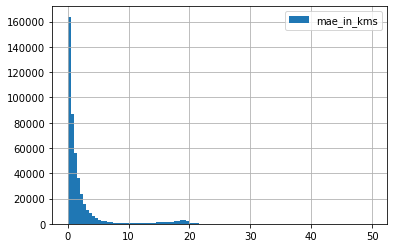

In [65]:
# seems like some of the taxis going to airport come back without a passenger
pred_df[pred_df["mae_in_kms"] < 50]["mae_in_kms"].hist(bins=100, legend=True)

In [66]:
baseline_mae = haversine((37.7749, -122.4194), (37.7749 + pred_means["pred_lat"], -122.4194 + pred_means["pred_lng"]))
print(f"Baseline mae in kms: {baseline_mae}")

Baseline mae in kms: 2.165774861432214


In [67]:
# lgb model is 22.4% better in terms of mae
human_readable_format((baseline_mae - cross_validation_mae) / baseline_mae)

'0.213'

Digging deeper into the LGB Model

In [68]:
threshold = int(len(lat_data) * 0.7)
lat_train_df, lat_test_df = lat_data.iloc[:threshold], lat_data.iloc[threshold:]
lat_train_labels, lat_test_labels = lat_labels.iloc[:threshold], lat_labels.iloc[threshold:]

lng_train_df, lng_test_df = lng_data.iloc[:threshold], lng_data.iloc[threshold:]
lng_train_labels, lng_test_labels = lng_labels.iloc[:threshold], lng_labels.iloc[threshold:]

In [69]:
def train_model(X_train, y_train, X_test, y_test, params):
    """Trains a model"""    
    training_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, y_test)
    print("Preparing final model...")
    bst = lgb.train(
        params, training_data,
        num_boost_round=NUM_BOOSTING_ROUNDS, 
        keep_training_booster=True, valid_sets=[training_data, test_data])
    return bst

In [70]:
lat_bst = train_model(lat_train_df, lat_train_labels, lat_test_df, lat_test_labels, lat_params)
lng_bst = train_model(lng_train_df, lng_train_labels, lng_test_df, lng_test_labels, lng_params)

Preparing final model...
[1]	training's l1: 0.022549	valid_1's l1: 0.0234727
[2]	training's l1: 0.0215614	valid_1's l1: 0.0225326
[3]	training's l1: 0.0207096	valid_1's l1: 0.0216991
[4]	training's l1: 0.0199731	valid_1's l1: 0.0210158
[5]	training's l1: 0.019334	valid_1's l1: 0.0203818
[6]	training's l1: 0.0187794	valid_1's l1: 0.0199134
[7]	training's l1: 0.0182926	valid_1's l1: 0.0194494
[8]	training's l1: 0.0178706	valid_1's l1: 0.0190637
[9]	training's l1: 0.017504	valid_1's l1: 0.018713
[10]	training's l1: 0.0171824	valid_1's l1: 0.0184065
[11]	training's l1: 0.016901	valid_1's l1: 0.0181607
[12]	training's l1: 0.0166526	valid_1's l1: 0.0179149
[13]	training's l1: 0.0164342	valid_1's l1: 0.0177667
[14]	training's l1: 0.0162423	valid_1's l1: 0.0175998
[15]	training's l1: 0.0160661	valid_1's l1: 0.0174561
[16]	training's l1: 0.0159085	valid_1's l1: 0.0173221
[17]	training's l1: 0.0157706	valid_1's l1: 0.017199
[18]	training's l1: 0.0156493	valid_1's l1: 0.0171167
[19]	training's l1

In [71]:
def print_statistics(bst, train_df, train_labels, test_df, test_labels):
    """Prints regression statistics"""
    train_predictions = bst.predict(train_df)
    test_predictions = bst.predict(test_df)
    print(f"Train R2 Score: {r2_score(train_labels, train_predictions)}")
    print(f"Test R2 Score: {r2_score(test_labels, test_predictions)}")
    print(f"Train MAE: {mean_absolute_error(train_labels, train_predictions)}")
    print(f"Test MAE: {mean_absolute_error(test_labels, test_predictions)}")

print("Lat Model")
print_statistics(lat_bst, lat_train_df, lat_train_labels, lat_test_df, lat_test_labels)
print("Lng Model")
print_statistics(lng_bst, lng_train_df, lng_train_labels, lng_test_df, lng_test_labels)

Lat Model
Train R2 Score: 0.4332069112858069
Test R2 Score: 0.36606660762470344
Train MAE: 0.014398326830194572
Test MAE: 0.016514592895563236
Lng Model
Train R2 Score: 0.5037399820448495
Test R2 Score: 0.46574477541796433
Train MAE: 0.00909019266339119
Test MAE: 0.009340391953006196


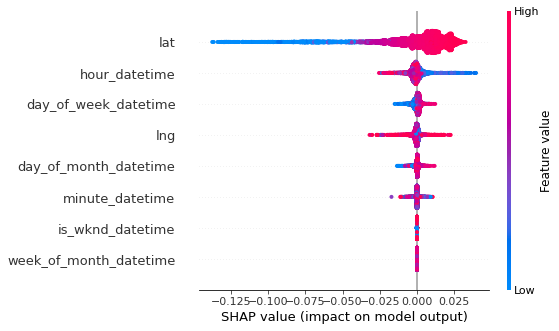

In [72]:
sampled_df = lat_train_df.sample(10000)
explainer = shap.TreeExplainer(lat_bst)
shap_values = explainer.shap_values(sampled_df)
shap.summary_plot(shap_values, sampled_df)

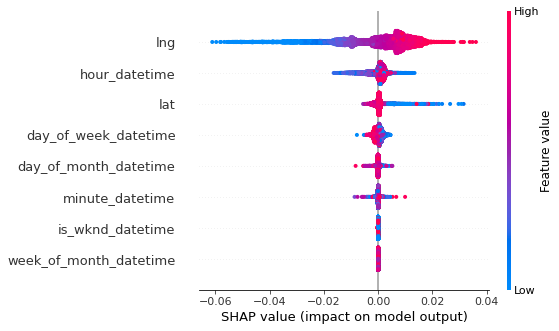

In [73]:
sampled_df = lng_train_df.sample(10000)
explainer = shap.TreeExplainer(lng_bst)
shap_values = explainer.shap_values(sampled_df)
shap.summary_plot(shap_values, sampled_df)

## Bonus: Clustering

In [74]:
sk_combined_pred_df = TrajDataFrame(combined_pred_df, timestamp=True)

In [75]:
cluster_df = clustering.cluster(
    sk_combined_pred_df[["lat", "lng", "datetime", "uid"]], cluster_radius_km=0.5, min_samples=1)

In [76]:
# skmob dataframes are buggy with group bys
cluster_df = pd.DataFrame(cluster_df).groupby("cluster").agg(
    number_of_trips=pd.NamedAgg(column="lat", aggfunc="count"),
    median_lat=pd.NamedAgg(column="lat", aggfunc="median"),
    median_lng=pd.NamedAgg(column="lng", aggfunc="median"))

In [77]:
# top 10 drop off locations
cluster_df.nlargest(10, "number_of_trips")

,number_of_trips,median_lat,median_lng
cluster,,,
0,385535,37.787150,-122.415010
1,18252,37.616340,-122.386320
2,5995,37.764560,-122.452890
3,3782,37.762630,-122.449450
4,2876,37.760655,-122.441290
5,2316,37.753660,-122.434015
6,1960,37.753610,-122.435815
7,1723,37.749620,-122.442660
8,1539,37.747740,-122.437630


In [78]:
# top 10 pick up locations
sk_combined_pred_df = TrajDataFrame(
    combined_pred_df[["next_lat", "next_lng", "datetime", "uid"]], latitude="next_lat", longitude="next_lng", 
    timestamp=True)

In [79]:
cluster_df = clustering.cluster(
    sk_combined_pred_df[["lat", "lng", "datetime", "uid"]], cluster_radius_km=0.5, min_samples=1)

In [80]:
# skmob dataframes are buggy with group bys
cluster_df = pd.DataFrame(cluster_df).groupby("cluster").agg(
    number_of_trips=pd.NamedAgg(column="lat", aggfunc="count"),
    median_lat=pd.NamedAgg(column="lat", aggfunc="median"),
    median_lng=pd.NamedAgg(column="lng", aggfunc="median"))
# top 10 pick-up locations
cluster_df.nlargest(10, "number_of_trips")

,number_of_trips,median_lat,median_lng
cluster,,,
0,397686,37.78736,-122.414170
1,21988,37.61614,-122.390070
2,6819,37.76444,-122.436810
3,4059,37.76270,-122.433780
4,2907,37.76086,-122.435920
5,2309,37.75799,-122.434070
6,1872,37.75518,-122.434955
7,1596,37.75125,-122.434000
8,1412,37.75313,-122.436585


You can plot the points using: https://mobisoftinfotech.com/tools/plot-multiple-points-on-map/

Red circle for drop-offs.

Yellow square for pick-ups.
```
37.78715,-122.41501,red,circle,386K
37.61634,-122.38632,red,circle,18.3K
37.76456,-122.45289,red,circle,6K
37.76263,-122.44945,red,circle,3.78K
37.760655,-122.44129,red,circle,2.88K
37.75366,-122.434015,red,circle,2.32K
37.75361,-122.43581499999999,red,circle,1.96K
37.74962,-122.44266,red,circle,1.72K
37.74774,-122.43763,red,circle,1.54K
37.74674,-122.44035,red,circle,1.41K
37.78736,-122.41417,yellow,square,398K
37.61614,-122.39007,yellow,square,22K
37.76444,-122.43681,yellow,square,6.82K
37.7627,-122.43378,yellow,square,4.06K
37.76086,-122.43592,yellow,square,2.91K
37.75799,-122.43407,yellow,square,2.31K
37.755179999999996,-122.434955,yellow,square,1.87K
37.75125,-122.434,yellow,square,1.6K
37.75313,-122.43658500000001,yellow,square,1.41K
37.75117,-122.43512,yellow,square,1.25K
```


### Unused codes

In [81]:
# using skmob, for sanity checking 
# sk_combined_df = skmob.TrajDataFrame(combined_df, timestamp=True)
# due to large number of samples this code block takes a lot of time
# the idea was to remove trajectories with invalid gps data where
# the speed is over 300km/h 

# removal of trajectories with incorrect data
# idle_df = skmob.preprocessing.filtering.filter(idle_df, max_speed_kmh=300)
# detection.stay_locations(df, stop_radius_factor=2.0, minutes_for_a_stop=20.0, spatial_radius_km=1.0, leaving_time=True)
# temp_df = clustering.cluster(df, cluster_radius_km=0.1, min_samples=1)
# temp_df.cluster.value_counts()
# kms covered by taxi cabs roaming without passengers by taxi id 
# for this analysis, I used skmob functions instead of my implementation that calculates distance
# distances_df = distance_straight_line(sk_combined_df[sk_combined_df["occupancy"] == 0])
# getting number of days active for each taxi
# this could have been done better by checking if the taxi is working in day X
# right now, it only looks into max and mins
# distances_df["num_days_active"] = combined_df.groupby("uid").agg(
#     num_days_active=pd.NamedAgg(column="datetime", aggfunc=day_range))["num_days_active"].values
# distances_df["distance_normalized_per_day"] = distances_df["distance_straight_line"] / distances_df["num_days_active"]
# distances_df = distances_df.set_index("uid")
# for i in cluster_df.nlargest(10, "number_of_trips").apply(lambda x: ",".join([str(x["median_lat"]), 
# str(x["median_lng"]), "yellow", "square", str(x["number_of_trips"])]), axis=1).values:
#     print(i)
# import dataframe_image as dfi
# # pd.DataFrame(distances_df.median().apply(human_readable_format), columns=["median"]
# dfi.export(combined_pred_df.head(), "new_data_model.png")